## import libraries

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyemma
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle

In [2]:
from MDAnalysis.lib.distances import calc_dihedrals
def calc_phi_psi(trajData):
    phis = calc_dihedrals(trajData[:,0,:], trajData[:,1,:], trajData[:,2,:], trajData[:,3,:])*180/3.14
    psis = calc_dihedrals(trajData[:,1,:], trajData[:,2,:], trajData[:,3,:], trajData[:,4,:])*180/3.14
    return phis,psis

# Metadynamics Simulation (Untempered)

### File locations for this simulation ->

In [3]:
data_path = "/scratch/projects/hockygroup/ss12902/metad_sims_ala2_using_same_tpr_TREX/bf1/"
gro_file = "run_ala2_metad_sigma0.3_height1.2_pace500.gro"
traj_file = "run_ala2_metad_sigma0.3_height1.2_pace500_wrapped.trr"
colvar_file = "run_ala2_metad_sigma0.3_height1.2_pace500.colvars.dat"

### load the data from COLVAR file ->

In [4]:
time, phi, psi, metad_bias, metad_rbias = np.loadtxt(data_path+colvar_file, usecols=(0,1,2,3,4), unpack=True)
time *= 1e-3      # in ns
phi *= 180/3.14   # in degrees
psi *= 180/3.14   # in degrees

### calculate the FES using rbias weights

In [5]:
## get the FE landscape
kbt = 0.596161  # @ 300K in kcal/mol unit
range_ = [-180,180]

# use weights from metad_rbias
hist, xedges, yedges = np.histogram2d(phi, psi, bins=30, range=[range_,range_], density=True, weights=np.exp(metad_rbias/kbt))
xgrids = (xedges[1:] + xedges[:-1])/2.0
ygrids = (yedges[1:] + yedges[:-1])/2.0

xx, yy = np.meshgrid(xgrids, ygrids)
fe = -kbt*np.log(hist)
fe -= fe.min()

### load GMM objects obtained using rbias frame weights

In [6]:
wsgmm_list_rbias = []
for i in range(3):
    with open(data_path+"w2/run_with_v1.6.1_kabsch_thresh_1e-1/wsgmm_%dstate.pickle"%(i+2), "rb") as fo:
        wsgmm = pickle.load(fo)
        wsgmm_list_rbias.append(wsgmm)

### load training and Cross Validation data from cluster scans

In [7]:
train = np.loadtxt(data_path+"w2/run_with_v1.6.1_kabsch_thresh_1e-1/train.dat")[:,1:]
cv = np.loadtxt(data_path+"w2/run_with_v1.6.1_kabsch_thresh_1e-1/cv.dat")[:,1:]

# train
train_mean = np.mean(train, axis=1)
train_std = np.std(train, axis=1)

# cv
cv_mean = np.mean(cv, axis=1)
cv_std = np.std(cv, axis=1)

In [8]:
# load train and cv data where we didn't use weights (or uniform weights)

train_wout = np.loadtxt(data_path+"run_with_v1.6.1_kabsch_thresh_1e-1/train.dat")[:,1:]
cv_wout = np.loadtxt(data_path+"run_with_v1.6.1_kabsch_thresh_1e-1/cv.dat")[:,1:]

# train
train_mean_wout = np.mean(train_wout, axis=1)
train_std_wout = np.std(train_wout, axis=1)

# cv
cv_mean_wout = np.mean(cv_wout, axis=1)
cv_std_wout = np.std(cv_wout, axis=1)

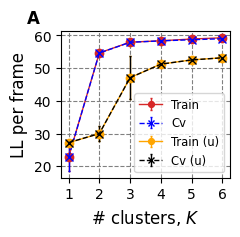

In [9]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# part- 1

fig, axs = plt.subplots(1, 1, figsize=(2.5, 2.5))

axs.text(-0.20, 1.05, "A", fontsize=12, fontweight="bold", transform=axs.transAxes)
axs.set_xlabel("# clusters, $K$", fontsize=12)
axs.set_ylabel("LL per frame", fontsize=12)
axs.set_xticks(np.arange(1,7))
axs.set_xticklabels(np.arange(1,7))  # change the fontsize on tick labels
axs.set_yticks(np.arange(20,70,10))
axs.set_yticklabels(np.arange(20,70,10))

axs.errorbar(np.arange(1,7), train_mean, train_std, fmt='-o', color="tab:red", lw=1, capsize=1, label="Train")
axs.errorbar(np.arange(1,7), cv_mean, cv_std, fmt='--x', color="blue", lw=1, capsize=1, label="Cv")

axs.errorbar(np.arange(1,7), train_mean_wout, train_std_wout, fmt='-o', color="orange", lw=1, capsize=1, label="Train (u)")
axs.errorbar(np.arange(1,7), cv_mean_wout, cv_std_wout, fmt='--x', color="black", lw=1, capsize=1, label="Cv (u)")

axs.legend(loc="lower right", fontsize="small", markerscale=0.7)
axs.grid(which='major', axis='both', color='#808080', linestyle='--')

fig.tight_layout()
plt.savefig("cscan_untemp_metad.pdf", format="pdf")

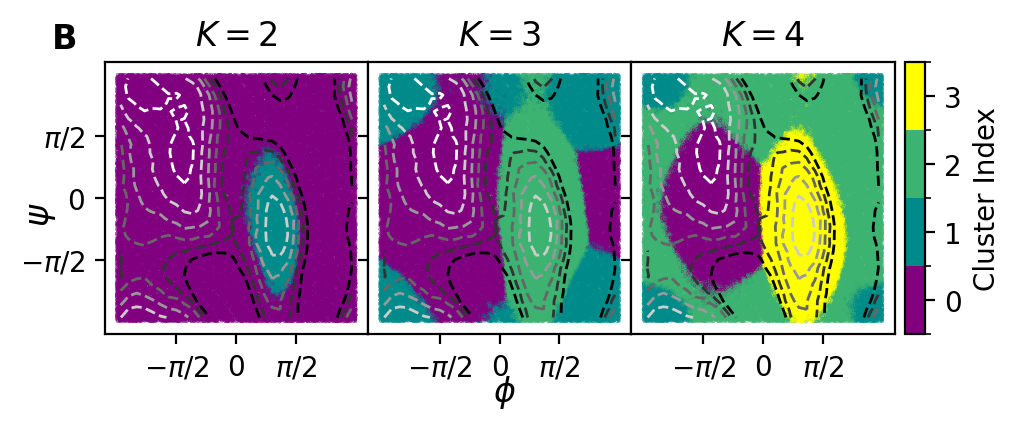

In [10]:
# part- 2

fig, axs = plt.subplots(1, 3, figsize=(5, 2), sharex=True, sharey=True, dpi=200)
fig.supxlabel("$\phi$")
fig.supylabel("$\psi$")

colors = ['purple', 'darkcyan', 'mediumseagreen', 'yellow']
cluster_boundaries = [0, 1, 2, 3, 4]  # You need one more boundary than the number of colors
cmap = ListedColormap(colors)
norm = BoundaryNorm(cluster_boundaries, cmap.N)

for i in range(3):
    if i == 0 :
        axs[i].set_yticks([-90,0,90])
        axs[i].set_yticklabels(["$-\pi/2$",0,"$\pi/2$"])
        axs[i].set_xticks([-90,0,90])
        axs[i].set_xticklabels(["$-\pi/2$",0,"$\pi/2$"])
        axs[i].text(-0.20, 1.05, "B", fontsize=12, fontweight="bold", transform=axs[i].transAxes)
    axs[i].set_title("$K=%d$"%(i+2))   
    axs[i].contour(xx, yy, fe.T, cmap="binary", linestyles="--", levels=np.arange(1,12,2), linewidths=1.0)
    im = axs[i].scatter(phi, psi, c=wsgmm_list_rbias[i].cluster_ids, marker=".", s=0.05, cmap=cmap, norm=norm)

# Create a common colorbar
cbar_ax = fig.add_axes([0.90, 0.20, 0.02, 0.68])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(0.5, 4, 1))
cbar.set_ticklabels(np.arange(4))
cbar.set_label('Cluster Index')
plt.subplots_adjust(wspace=0, left=0.1, bottom=0.2, right=0.89)
                                           
plt.savefig("untemp_scatters_only.png")

# Metadynamics Simulation (BF=10)

### File locations for this simulation ->

In [11]:
data_path = "/scratch/projects/hockygroup/ss12902/metad_sims_ala2_using_same_tpr_TREX/bf10/"
gro_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10.gro"
traj_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10_wrapped.trr"
colvar_file = "run_ala2_metad_sigma0.3_height1.2_pace500_bf10.colvars.dat"

### load the data from COLVAR file ->

In [12]:
time, phi, psi, metad_bias, metad_rbias = np.loadtxt(data_path+colvar_file, usecols=(0,1,2,3,4), unpack=True)
time *= 1e-3      # in ns
phi *= 180/3.14   # in degrees
psi *= 180/3.14   # in degrees

### load the final bias ->

In [13]:
metad_fbias = np.loadtxt(data_path+"colvar_reweight", usecols=3)
metad_fbias -= metad_fbias.min()

In [14]:
# list of biases 
biases = [metad_bias, metad_rbias, metad_fbias]

### calculate the FES for different choice of weights ->

In [15]:
nbins = 30
range_ = [-180,180]
fes_data = []
for i in range(4):
    
    if i == 0:
        # not using any weights
        hist, xedges, yedges = np.histogram2d(phi, psi, bins=[nbins,nbins], range=[range_,range_], density=True)
    else:
        # using proper weights
        hist, xedges, yedges = np.histogram2d(phi, psi, bins=[nbins,nbins], range=[range_,range_], density=True, weights=np.exp(biases[i-1]/kbt))
    
    xgrids = (xedges[1:] + xedges[:-1])/2.0
    ygrids = (yedges[1:] + yedges[:-1])/2.0
    
    xx, yy = np.meshgrid(xgrids, ygrids)
    fe = -kbt*np.log(hist)
    fe -= fe.min()
    
    out_arr = [xx, yy, fe]
    fes_data.append(out_arr)
fes_data = np.array(fes_data)
print(fes_data.shape)

(4, 3, 30, 30)


### load the clustered objects for different weights and different clusters ->

In [16]:
wsgmm_list = []

# loop over different weights (w1, w2 and w3)
for i in range(3):
    objs = []
    
    # loop over different clusters (2 to 6)
    for j in range(5):
        
        # load pickled object
        with open(data_path+"w%d/run_with_v1.6.1/kabsch_thresh_1e-1/wsgmm_%dstate_nattempts_40.pickle"%(i+1, j+2), "rb") as fo:
            obj = pickle.load(fo)
        
        objs.append(obj)
    
    wsgmm_list.append(objs)
        
wsgmm_list = np.array(wsgmm_list)
print(wsgmm_list.shape)

(3, 5)


### load the clustered objects obtained from using uniform weights ->

In [17]:
objs_uniform = []
for i in range(5):
    with open(data_path+"run_with_v1.6.1/wsgmm_%dstate_wout_weights_nattempts_40.pickle"%(i+2), "rb") as fo:
        obj_ = pickle.load(fo)
    objs_uniform.append(obj_)
    
objs_uniform = np.array(objs_uniform)

print(objs_uniform.shape)

(5,)


In [18]:
all_wsgmm = np.concatenate([objs_uniform.reshape(1,5), wsgmm_list], axis=0)
print(all_wsgmm.shape)

(4, 5)


### load the train and cv files for each case ->

In [19]:
paths = ["run_with_v1.6.1", "w1/run_with_v1.6.1", "w2/run_with_v1.6.1", "w3/run_with_v1.6.1"]
#paths = ["w1", "w2", "w3"]

mean_data = []
std_data = []

for i in range(4):
#for i in range(3):    
    
    # load
    train = np.loadtxt(data_path+paths[i]+"/train.dat")[:,1:]
    cv = np.loadtxt(data_path+paths[i]+"/cv.dat")[:,1:]
    
    # train
    train_mean = np.mean(train, axis=1)
    train_std = np.std(train, axis=1)
    
    # cv
    cv_mean = np.mean(cv, axis=1)
    cv_std = np.std(cv, axis=1)
    
    # append
    mean_data.append([train_mean, cv_mean])
    std_data.append([train_std, cv_std])
    
mean_data = np.array(mean_data)
std_data = np.array(std_data)

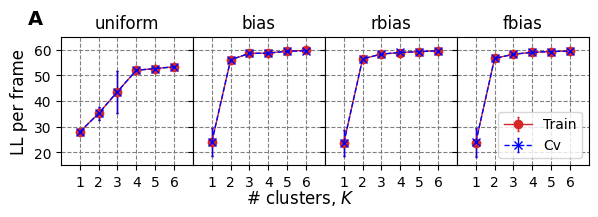

In [20]:
import string 

fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(6,2.1))
titles = ["uniform", "bias", "rbias", "fbias"]
fig.supxlabel("# clusters, $K$", fontsize=12)
for i in range(4):
    if i == 0:
        axs[i].text(-0.25, 1.1, string.ascii_uppercase[0], fontsize=14, fontweight="bold", transform=axs[i].transAxes)
        axs[i].set_ylabel("LL per frame", fontsize=12)
    axs[i].set_title(titles[i], fontsize=12)
    
    # set limits
    axs[i].set_xlim(0,7)
    axs[i].set_ylim(15,65)
    
    # set y-ticks
    axs[i].set_yticks([20,30,40,50,60])
    axs[i].set_yticklabels([20,30,40,50,60])
    
    # set x-ticks
    axs[i].set_xticks(np.arange(1,7))
    axs[i].set_xticklabels(np.arange(1,7))
    
    # plot
    axs[i].errorbar(np.arange(1,7), mean_data[i,0,:], std_data[i,0,:], fmt='-o', color="tab:red", lw=1, capsize=1, label="Train")
    axs[i].errorbar(np.arange(1,7), mean_data[i,1,:], std_data[i,1,:], fmt='--x', color="blue", lw=1, capsize=1, label="Cv")
    if i == 3:
        axs[i].legend(loc="lower right")
    axs[i].grid(which='major', axis='both', color='#808080', linestyle='--')
fig.subplots_adjust(wspace=0.0, bottom=0.21, right=0.98, left=0.1, top=0.82)
plt.savefig("cluster_scans_difft_bias_adp_updated_2.pdf", format="pdf")

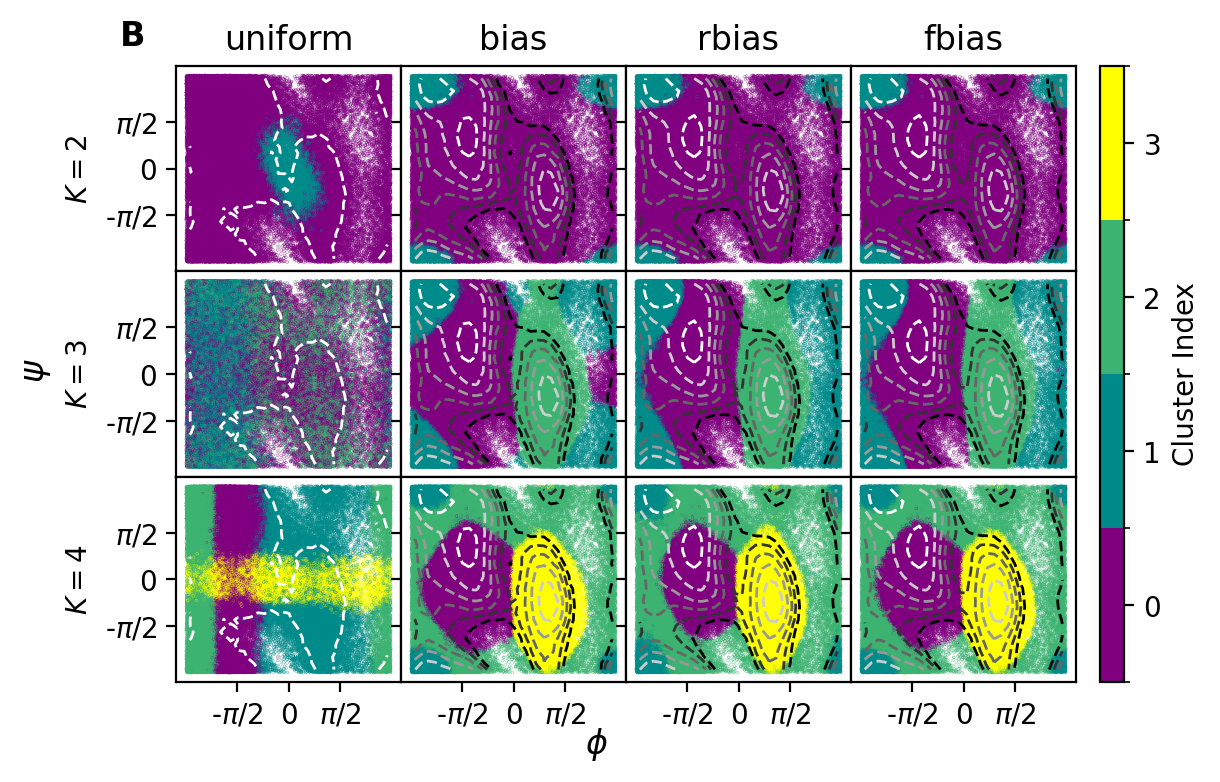

In [21]:
from matplotlib.colors import ListedColormap, BoundaryNorm

colors = ['purple', 'darkcyan', 'mediumseagreen','yellow']
cluster_boundaries = [0, 1, 2, 3, 4]  # You need one more boundary than the number of colors

cmap = ListedColormap(colors)
norm = BoundaryNorm(cluster_boundaries, cmap.N)

fig, axs = plt.subplots(3, 4, figsize=(6,4), sharex=True, sharey=True, dpi=200)
fig.supxlabel("$\phi$")
fig.supylabel("$\psi$")
titles = ["uniform", "bias", "rbias", "fbias"]


axs[0,0].set_xticks([-90,0,90])
axs[0,0].set_xticklabels(["-$\pi/2$", 0, "$\pi/2$"])
axs[0,0].set_yticks([-90,0,90])
axs[0,0].set_yticklabels(["-$\pi/2$", 0, "$\pi/2$"])
axs[0,0].text(-0.25, 1.1, string.ascii_uppercase[1], fontsize=12, fontweight="bold", transform=axs[0,0].transAxes)

# loop over cluster sizes
for i in range(3):
    
    # loop over the different weights
    for j in range(4):
        
        if i == 0:
            axs[i,j].set_title(titles[j])
            
        if j == 0:
            axs[i,j].set_ylabel("$K = %d$"%(i+2))

        # plot
        axs[i,j].contour(fes_data[j,0,:,:], fes_data[j,1,:,:], fes_data[j,2,:,:].T, cmap="binary", levels=np.arange(1,12,2), linestyles="--", linewidths=1.0)

        im = axs[i,j].scatter(phi, psi, c=all_wsgmm[j,i].cluster_ids, cmap=cmap, marker=".", s=0.05, norm=norm)
        
# Create a common colorbar
cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(0.5,4,1))
cbar.set_ticklabels(np.arange(4))

# Optionally, add a label to the colorbar
cbar.set_label('Cluster Index')
fig.subplots_adjust(wspace=0.0, hspace=0.0, left=0.15)
        
plt.savefig("bf10_all_updated_2.png")

## load the Metad reference FE for BF=10 simulation

In [22]:
metad_fe_sumhills = np.loadtxt(os.path.join(data_path,"2d_fe_phi_psi_sum_hill_bf10_nbins_100.txt"))[:,2]
metad_fe_sumhills = metad_fe_sumhills.reshape((100,100))

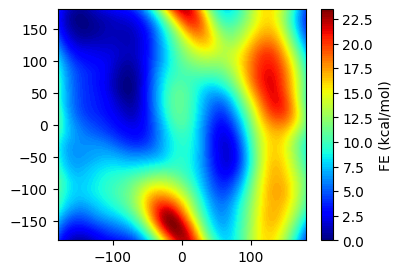

In [23]:
grids_ = np.linspace(-180, 180, 100, endpoint=True, dtype=float)
plt.figure(figsize=(4,3))
plt.contourf(grids_, grids_, metad_fe_sumhills, cmap=plt.get_cmap("jet"), levels=100)
cbar = plt.colorbar()
cbar.set_label("FE (kcal/mol)")

## Calculate the FEs from GMMs using Monte Carlo procedure

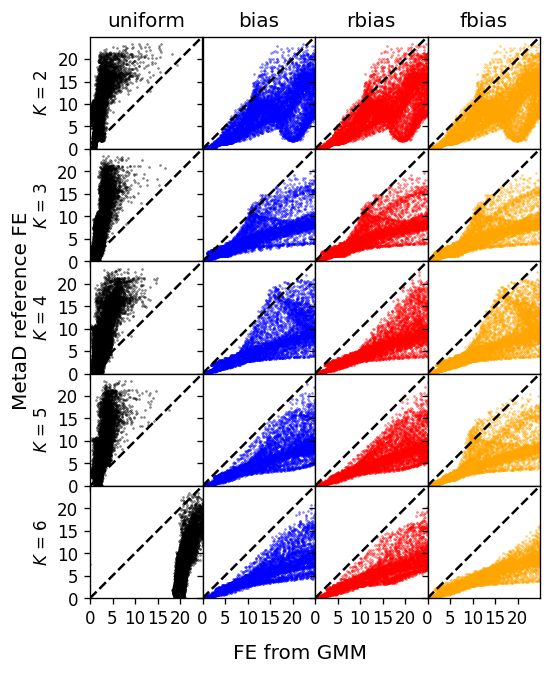

In [24]:
fe_sgmm = np.empty((4,5, 100, 100))
labels = ["uniform", "bias", "rbias", "fbias"]
colors_list = ["black", "blue", "red", "orange"]

fig, ax = plt.subplots(5,4,figsize=(5,6), dpi=120, sharex=True, sharey=True)

ax[0,0].set_xlim(0,25)
ax[0,0].set_xticks(np.arange(0,25,5))

ax[0,0].set_ylim(0,25)
ax[0,0].set_yticks(np.arange(0,25,5))

ax[0,0].set_box_aspect(1)

for i in range(4):
    for j in range(5):
        
        H, x, y = np.histogram2d(phi, psi, bins=metad_fe_sumhills.shape, range=[range_, range_], weights=np.exp(all_wsgmm[i,j].train_frame_log_likelihood))
        binweight = np.histogram2d(phi, psi, bins=metad_fe_sumhills.shape, range=[range_, range_], weights=np.ones(phi.shape[0]))[0]
        
        fe = -kbt*(np.log(H) - np.log(binweight))
        
        fe -= fe[~np.isnan(fe)].min()
        fe_sgmm[i,j,:,:] = fe

        ax[j,i].scatter(fe.T.flatten(), metad_fe_sumhills.flatten(), s=0.2, color=colors_list[i], alpha=0.6)
        
        if j == 0:
            ax[j,i].set_title(labels[i])
        if i == 0:
            ax[j,i].set_ylabel("$K$ = %d"%(j+2))
            
        ax[j,i].plot(np.arange(0,25,0.1),np.arange(0,25,0.1),linestyle='--',c='k')

fig.supxlabel("FE from GMM")
fig.supylabel("MetaD reference FE")
fig.subplots_adjust(wspace=0, hspace=0, bottom=0.1, left=0.15)

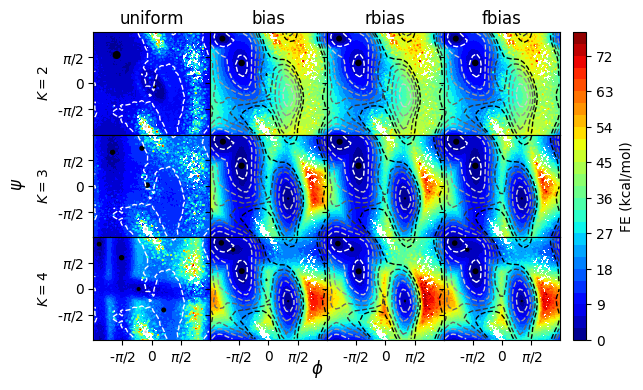

In [25]:
fig, axs  = plt.subplots(3,4, figsize=(6.4,4), sharex=True, sharey=True)
xbins = (x[1:]+x[:-1])/2.0
ybins = (y[1:]+y[:-1])/2.0

fig.supxlabel("$\phi$")
fig.supylabel("$\psi$")

axs[0,0].set_xticks([-90,0,90])
axs[0,0].set_xticklabels(["-$\pi/2$", 0, "$\pi/2$"])
axs[0,0].set_yticks([-90,0,90])
axs[0,0].set_yticklabels(["-$\pi/2$", 0, "$\pi/2$"])

# loop over sizes
for i in range(3):
    # loop over weights
    for j in range(4):
        
        if i == 0:
            axs[i,j].set_title(labels[j])
            
        if j == 0:
            axs[i,j].set_ylabel("$K = %d$"%(i+2))
        
        # get phis-psis for cluster centers ->
        phis_centers, psis_centers = calc_phi_psi(all_wsgmm[j,i].centers)
        
        im = axs[i,j].contourf(xbins, ybins, fe_sgmm[j,i].T, cmap="jet", levels=25)
        axs[i,j].scatter(phis_centers, psis_centers, marker="o", s=all_wsgmm[j,i].weights*25.0, color="k")
        axs[i,j].contour(fes_data[j,0,:,:], fes_data[j,1,:,:], fes_data[j,2,:,:].T, cmap="binary", levels=np.arange(1,12,2), linestyles="--", linewidths=1.0)
        
# Create a common colorbar
cbar_ax = fig.add_axes([0.90, 0.11, 0.02, 0.77])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)

# Optionally, add a label to the colorbar
cbar.set_label('FE (kcal/mol)')
fig.subplots_adjust(wspace=0.0, hspace=0.0, left=0.15, right=0.88)

plt.savefig("fe_sgmm_all_bf10_updated_2.pdf")

In [26]:
print(fe_sgmm.shape)
print(metad_fe_sumhills.shape)

(4, 5, 100, 100)
(100, 100)


## calculate the FES from GMM objects (using MV generator) 

###  Generate 1M samples from each GMM object 

In [27]:
traj_all_bckup = np.load("traj_all_bckup.npy", allow_pickle=True).reshape([4,5,1000000,5,3])
print(traj_all_bckup.shape)

(4, 5, 1000000, 5, 3)


0.0 1.8987574476807305
0.0 5.565182498579738
0.0 5.565182498579737
0.0 5.5882039552819
0.0 1.8618072577288647
0.0 5.564076301575804
0.0 5.5477743216564095
0.0 5.572349176119482
0.0 3.9490093502704253
0.0 5.638153786280326
0.0 5.647440474705897
0.0 5.647669652811974


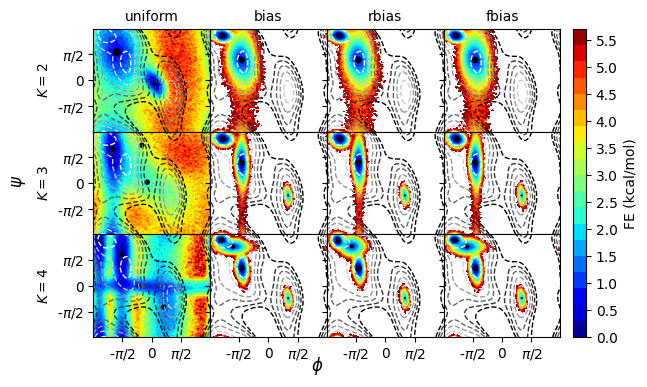

In [28]:
nbins = metad_fe_sumhills.shape
kbt = 0.596161  # @ 300K in kcal/mol unit
range_ = [-180,180]

fig, axs = plt.subplots(3, 4, figsize=(6.4,4), sharex=True, sharey=True)
fig.supxlabel("$\phi$")
fig.supylabel("$\psi$")
titles = ["uniform", "bias", "rbias", "fbias"]


axs[0,0].set_xticks([-90,0,90])
axs[0,0].set_xticklabels(["-$\pi/2$", 0, "$\pi/2$"])
axs[0,0].set_yticks([-90,0,90])
axs[0,0].set_yticklabels(["-$\pi/2$", 0, "$\pi/2$"])

# loop over the sizes
for i in range(3):
    
    # loop over the weights
    for j in range(4):
        
        if i ==0 :
            axs[i,j].set_title(titles[j], fontsize=10.0)
        
        if j == 0:
            axs[i,j].set_ylabel("$K = %d$"%(i+2))
        
        traj = traj_all_bckup[j,i,:,:,:]
        
        # get phis-psis
        phis, psis = calc_phi_psi(traj)
        
        # get phis-psis for cluster centers ->
        phis_centers, psis_centers = calc_phi_psi(all_wsgmm[j,i].centers)
        
        # histogram
        hist, xedges, yedges = np.histogram2d(phis, psis, bins=nbins, range=[range_, range_], density=True)

        xcenters = (xedges[1:]+xedges[:-1])/2.0
        ycenters = (yedges[1:]+yedges[:-1])/2.0
        
        fe = -kbt*np.log(hist)
        fe -= fe.min()
                
        im = axs[i,j].contourf(xcenters, ycenters, fe.T, cmap="jet", levels=20)        
        print(np.amin(fe), np.amax(fe[np.isfinite(fe)]))
        axs[i,j].contour(xcenters, ycenters, metad_fe_sumhills, cmap="binary", levels=np.arange(1,12,2), linestyles="--", linewidths=1.0)
        axs[i,j].scatter(phis_centers, psis_centers, marker="o", s=all_wsgmm[j,i].weights*25.0, color="k")

        
# Create a common colorbar
cbar_ax = fig.add_axes([0.90, 0.11, 0.02, 0.77])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)

# Optionally, add a label to the colorbar
cbar.set_label('FE (kcal/mol)')
cbar.set_ticks(np.arange(0, 6, 0.5))
cbar.set_ticklabels(np.arange(0, 6, 0.5))

fig.subplots_adjust(wspace=0.0, hspace=0.0, left=0.15, right=0.88)

plt.savefig("fes_from_gmms_mv_generated_data_bf10_metad_clusters_updated_2.pdf")

### make the same figrure for size 5 and 6 only

0.0 2.469186246865786
0.0 5.591939122356104
0.0 5.599041720168786
0.0 5.46539039429649
0.0 3.967713974715532
0.0 5.6510056588341016
0.0 5.609539432244026
0.0 5.642376137354767


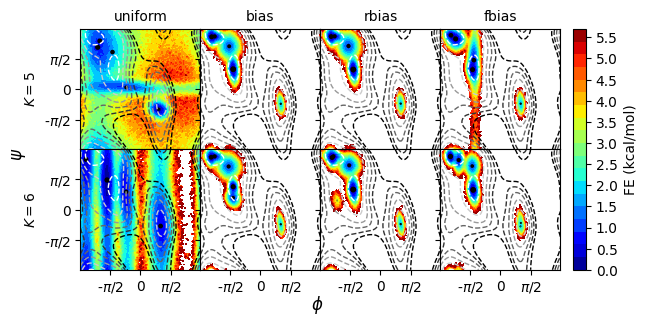

In [29]:
nbins = metad_fe_sumhills.shape
kbt = 0.596161  # @ 300K in kcal/mol unit
range_ = [-180,180]

fig, axs = plt.subplots(2, 4, figsize=(6.4,3.3), sharex=True, sharey=True)
fig.supxlabel("$\phi$")
fig.supylabel("$\psi$")
titles = ["uniform", "bias", "rbias", "fbias"]


axs[0,0].set_xticks([-90,0,90])
axs[0,0].set_xticklabels(["-$\pi/2$", 0, "$\pi/2$"])
axs[0,0].set_yticks([-90,0,90])
axs[0,0].set_yticklabels(["-$\pi/2$", 0, "$\pi/2$"])

# loop over the sizes
for i in [3,4]:
    
    # loop over the weights
    for j in range(4):
        
        if i ==3 :
            axs[i-3,j].set_title(titles[j], fontsize=10.0)
        
        if j == 0:
            axs[i-3,j].set_ylabel("$K = %d$"%(i+2))
        
        traj = traj_all_bckup[j,i,:,:,:]
        
        # get phis-psis
        phis, psis = calc_phi_psi(traj)
        
        # get phis-psis for cluster centers ->
        phis_centers, psis_centers = calc_phi_psi(all_wsgmm[j,i].centers)
        
        # histogram
        hist, xedges, yedges = np.histogram2d(phis, psis, bins=nbins, range=[range_, range_], density=True)

        xcenters = (xedges[1:]+xedges[:-1])/2.0
        ycenters = (yedges[1:]+yedges[:-1])/2.0
        
        fe = -kbt*np.log(hist)
        fe -= fe.min()
                
        im = axs[i-3,j].contourf(xcenters, ycenters, fe.T, cmap="jet", levels=20)        
        print(np.amin(fe), np.amax(fe[np.isfinite(fe)]))
        axs[i-3,j].contour(xcenters, ycenters, metad_fe_sumhills, cmap="binary", levels=np.arange(1,12,2), linestyles="--", linewidths=1.0)
        axs[i-3,j].scatter(phis_centers, psis_centers, marker="o", s=all_wsgmm[j,i].weights*25.0, color="k")

        
# Create a common colorbar
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.73])  # [x, y, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)

# Optionally, add a label to the colorbar
cbar.set_label('FE (kcal/mol)')
cbar.set_ticks(np.arange(0, 6, 0.5))
cbar.set_ticklabels(np.arange(0, 6, 0.5))

fig.subplots_adjust(wspace=0.0, hspace=0.0, left=0.13, right=0.88, bottom=0.15)

plt.savefig("fes_from_gmms_size_5and6.pdf", format="pdf")